In [3]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
import os

# Feature Extraction

In [4]:
def aggregate_features(df, window_size=10):
    df['datetime'] = pd.to_datetime(df['datetime'])
    df = df.sort_values(by=['id', 'datetime'])
    df['window'] = df.groupby('id')['datetime'].transform(lambda x: (x - x.min()).dt.total_seconds() // window_size)

    aggregated = df.groupby(['id', 'window']).agg({
        'X': ['mean', 'min', 'max', 'std'],
        'Y': ['mean', 'min', 'max', 'std'],
        'Z': ['mean', 'min', 'max', 'std'],
        'EDA': ['mean', 'min', 'max', 'std', skew, kurtosis],
        'HR': ['mean', 'min', 'max', 'std'],
        'TEMP': ['mean', 'min', 'max', 'std'],
        'label': 'first'  # Assume that the label does not change within a window
    })

    aggregated.columns = ['_'.join(col).strip() for col in aggregated.columns.values]
    aggregated.reset_index(inplace=True)

    return aggregated

TO DO: implement overlap windows using shift

In [5]:
data = pd.read_csv('merged_data.csv')
window_size = 10
result = aggregate_features(data, window_size=window_size)
result.drop(columns=['id', 'window'], axis=1, inplace=True)
print(result.shape)
result.to_csv(f'aggregated_data_{window_size}_window.csv', index=False)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_21360\3474319258.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('merged_data.csv')


(35850, 27)


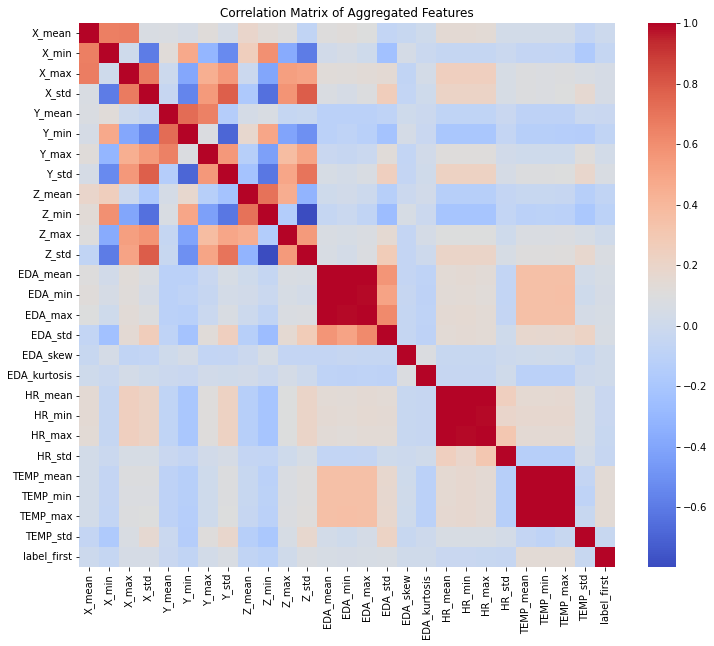

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = result.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=False, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix of Aggregated Features')
plt.show()

# Feature Selection

In [7]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

In [8]:
def remove_highly_correlated_features(X, threshold=0.9):
    corr_matrix = X.corr().abs()
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]
    return X.drop(columns=to_drop, errors='ignore')

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE, mutual_info_classif

def enforce_main_feature_selection(X, selected_features, scores):
    main_features = ['X', 'Y', 'Z', 'EDA', 'HR', 'TEMP']
    for feature in main_features:
        variants = [col for col in X.columns if col.startswith(feature)]
        if not any(var in selected_features for var in variants):
            best_variant = max(variants, key=lambda v: scores.get(v, 0))
            selected_features.append(best_variant)
    return X[selected_features], selected_features

def mutual_info_feature_selection(X, y, k=10):
    mi = mutual_info_classif(X, y, discrete_features=False)
    mi_scores = pd.Series(mi, index=X.columns).sort_values(ascending=False)
    selected_features = mi_scores.head(k).index.tolist()
    return enforce_main_feature_selection(X, selected_features, mi_scores)

def rfe_feature_selection(X, y, k=10):
    model = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
    rfe = RFE(model, n_features_to_select=k)
    rfe.fit(X, y)
    selected_features = X.columns[rfe.support_].tolist()
    model.fit(X[selected_features], y)
    importance_scores = pd.Series(model.feature_importances_, index=selected_features)
    return enforce_main_feature_selection(X, selected_features, importance_scores)


In [ ]:
def feature_selection(df, method='mutual_info', k=10):
    X = df.drop(columns=['label_first'])
    y = df['label_first']

    # Remove features with low variance
    selector = VarianceThreshold(threshold=0.01)
    X = pd.DataFrame(selector.fit_transform(X), columns=X.columns[selector.get_support()])

    # Eliminate highly correlated features
    X = remove_highly_correlated_features(X, threshold=0.9)

    # Normalize features
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

    X_scaled.replace([np.inf, -np.inf], np.nan, inplace=True)
    X_scaled.dropna(inplace=True)
    y = y.loc[X_scaled.index]

    # Feature selection method
    if method == 'mutual_info':
        X_selected, selected_features = mutual_info_feature_selection(X_scaled, y, k)
    elif method == 'rfe':
        X_selected, selected_features = rfe_feature_selection(X_scaled, y, k)

    return X_selected, y

In [12]:
X_selected, y = feature_selection(result, method='mutual_info', k=10)
print(f"Selected features: {X_selected.columns.tolist()}")

Selected features: ['EDA_mean', 'TEMP_mean', 'Z_min', 'X_mean', 'Z_mean', 'Y_mean', 'Z_std', 'EDA_std', 'X_min', 'Y_min', 'HR_mean']


In [13]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(y)

In [14]:
values, counts = np.unique(y, return_counts=True)
value_counts_dict = dict(zip(values, counts))
print(value_counts_dict)

{0: 6762, 1: 2420, 2: 26485}


# Model Implementation

In [15]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost.sklearn import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.preprocessing import label_binarize

In [16]:
def train_and_evaluate_models(X, y, test_size=0.2, random_state=42):
    if not os.path.exists("results"):
        os.makedirs("results")
        
    # Define base models (we will tune each one)
    base_models = {
        'SVM': SVC(probability=True, random_state=random_state),
        'Random Forest': RandomForestClassifier(random_state=random_state),
        'XGBoost': XGBClassifier(objective="multi:softmax", num_class=len(np.unique(y))),
        'KNN': KNeighborsClassifier(),
        'AdaBoost': AdaBoostClassifier(random_state=random_state),
        'Gradient Boosting': GradientBoostingClassifier(random_state=random_state)
    }

    param_distributions = {
        'SVM': {
            'C': [0.1, 1, 10, 20],
            'kernel': ['linear', 'rbf', 'poly'],
            'gamma': ['scale']
        },
        'Random Forest': {
            'n_estimators': [25, 50, 100],
            'max_depth': [None, 5, 10, 20],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        },
        'XGBoost': {
            'n_estimators': [25, 50, 100],
            'learning_rate': [0.05, 0.1, 0.2],
            'max_depth': [3, 5, 7]
        },
        'KNN': {
            'n_neighbors': [3, 5, 7, 10],
            'weights': ['uniform', 'distance']
        },
        'AdaBoost': {
            'n_estimators': [25, 50, 100],
            'learning_rate': [0.05, 0.1, 0.2]
        },
        'Gradient Boosting': {
            'n_estimators': [25, 50, 100],
            'learning_rate': [0.05, 0.1, 0.2],
            'max_depth': [3, 5, 7]
        }
    }

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    results = {}

    y_test_bin = label_binarize(y_test, classes=np.unique(y))
    n_classes = y_test_bin.shape[1]

    # We'll iterate over each model, perform HalvingRandomSearchCV, and evaluate
    for name, base_model in base_models.items():
        print(f"\nTuning and training model: {name}")
        search = HalvingRandomSearchCV(
            estimator=base_model,
            param_distributions=param_distributions[name],
            factor=3,
            # n_iter=5, # number of parameter settings sampled
            cv=3,
            # scoring='accuracy',
            random_state=random_state,
            n_jobs=-1
        )
        # Fit HalvingRandomSearchCV on the training data
        search.fit(X_train, y_train)
        best_model = search.best_estimator_
        print(f"Best parameters for {name}: {search.best_params_}")
        print(f"Best CV score for {name}: {search.best_score_:.4f}")

        # Evaluate on test data
        y_pred = best_model.predict(X_test)
        y_proba = best_model.predict_proba(X_test)

        report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
        results[name] = report['weighted avg']
        results[name].update({'accuracy': report['accuracy']})

        # Save classification report to CSV
        df_report = pd.DataFrame(report).T
        df_report.to_csv(f'results/{name}_classification_report.csv', index=False)

        # Plot and save confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(10, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix - {name}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.savefig(f'results/{name}_confusion_matrix.png')
        plt.close()

        # ROC Curve (Micro y Macro Average)
        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        # Micro-Average ROC Curve
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_proba.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
        results[name]['roc_auc_micro'] = roc_auc["micro"]
        plt.plot(fpr["micro"], tpr["micro"], label=f'{name} (Micro AUC = {roc_auc["micro"]:.2f})', linestyle=':')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison')
    plt.legend()
    plt.savefig('results/roc_curve_comparison.png')

    return results


Tuning and training model: SVM


c:\Users\Usuario\anaconda3\envs\stress\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 12 is smaller than n_iter=1585. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters for SVM: {'kernel': 'rbf', 'gamma': 'scale', 'C': 1}
Best CV score for SVM: 0.7284

Tuning and training model: Random Forest


c:\Users\Usuario\anaconda3\envs\stress\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 48 is smaller than n_iter=1585. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters for Random Forest: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': None}
Best CV score for Random Forest: 0.7551

Tuning and training model: XGBoost


c:\Users\Usuario\anaconda3\envs\stress\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 27 is smaller than n_iter=1585. Running 27 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters for XGBoost: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05}
Best CV score for XGBoost: 0.7634

Tuning and training model: KNN


c:\Users\Usuario\anaconda3\envs\stress\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 8 is smaller than n_iter=1585. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters for KNN: {'weights': 'uniform', 'n_neighbors': 10}
Best CV score for KNN: 0.6481

Tuning and training model: AdaBoost


c:\Users\Usuario\anaconda3\envs\stress\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 9 is smaller than n_iter=1585. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters for AdaBoost: {'n_estimators': 100, 'learning_rate': 0.2}
Best CV score for AdaBoost: 0.7160

Tuning and training model: Gradient Boosting


c:\Users\Usuario\anaconda3\envs\stress\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 27 is smaller than n_iter=1585. Running 27 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters for Gradient Boosting: {'n_estimators': 25, 'max_depth': 5, 'learning_rate': 0.05}
Best CV score for Gradient Boosting: 0.7428


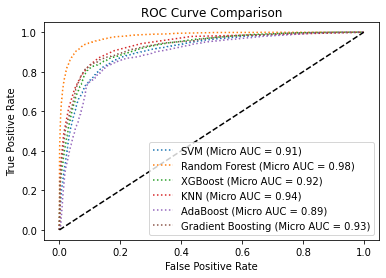

In [17]:
results = train_and_evaluate_models(X_selected, y)

# Model Evaluation and Results

In [18]:
def plot_model_comparison(classification_reports):
    metrics = ["precision", "recall", "f1-score", "accuracy"]
    models = list(classification_reports.keys())

    data = {metric: [classification_reports[model][metric] for model in models] for metric in metrics}
    df = pd.DataFrame(data, index=models)

    # Grouped Bar Chart
    fig, ax = plt.subplots(figsize=(12, 8))
    df.plot(kind='bar', width=0.7, colormap='viridis', edgecolor='black', alpha=0.75, ax=ax)
    plt.title("Comparison of Classification Metrics")
    plt.ylabel("Value")
    plt.xticks(rotation=45)
    plt.legend(title="Metric")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.savefig('results/classification_metrics_bars.jpg', bbox_inches='tight')

    # Spider Chart
    categories = metrics
    num_vars = len(categories)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
    for model, scores in df.iterrows():
        values = scores.tolist()
        values += values[:1]
        ax.plot(angles, values, label=model, linewidth=2)
        ax.fill(angles, values, alpha=0.2)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=12)
    ax.set_yticklabels([])
    ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
    ax.set_title("Comparison of Classification Metrics")
    plt.savefig('results/classification_metrics_spider.jpg', bbox_inches='tight')

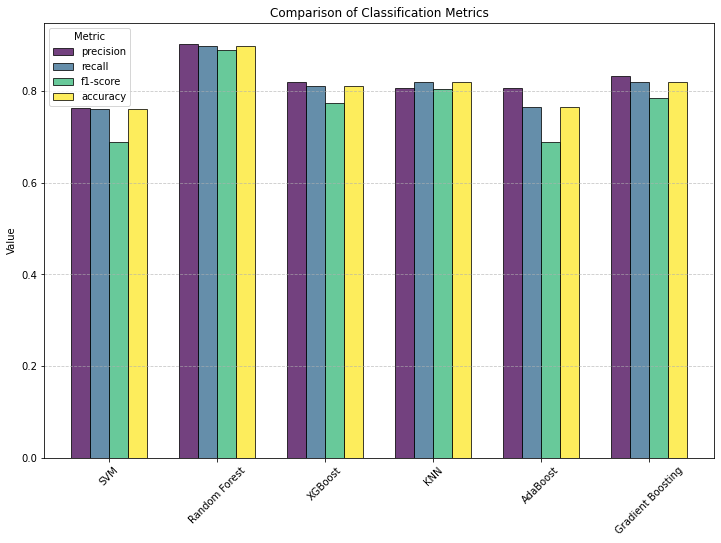

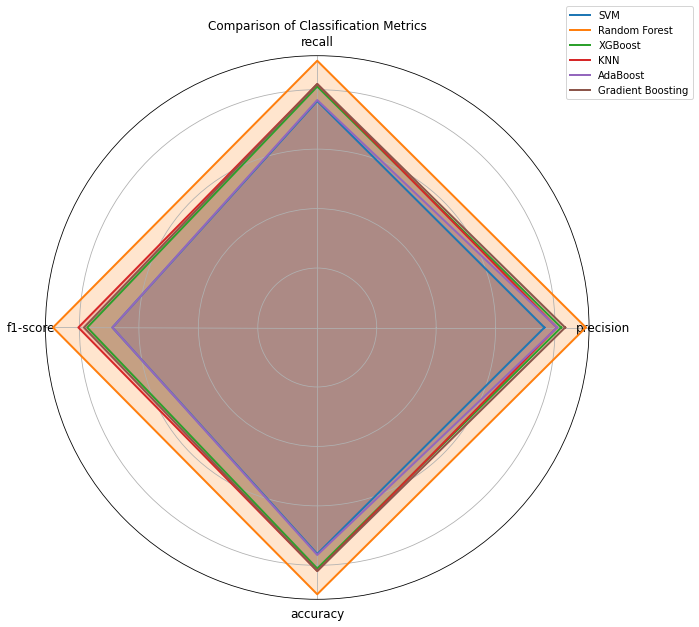

In [19]:
plot_model_comparison(results)